In [1]:
# File
import glob

import pandas as pd
import matplotlib.pyplot as plt

#
import torchio as tio

/home/ids/mahdi-22/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch

# Data Loading and Visualization

## Metadata

In [2]:
metadata_path = "/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")

In [4]:
metadata

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN
...,...,...,...,...,...,...,...,...,...,...
T2Z1Z9,Canon,D,5,29,9,43,HCM,F,162.0,93.0
T9U9W2,Siemens,A,1,0,10,57,HCM,M,160.0,68.0
V4W8Z5,GE,C,4,19,9,39,Other,F,NaN,55.0


## NII files

In [41]:
def get_subjects_names(dir, root_dir="/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/", verbose=False):
  subjects_names = glob.glob("*", root_dir=root_dir+dir)
  if verbose:
    print(f"subjects for {dir[:-1]}: {len(subjects_names)}")
  return subjects_names

training_subjects = get_subjects_names("Training/Labeled/", verbose=True)
validation_subjects = get_subjects_names("Validation/", verbose=True)
testing_subjects = get_subjects_names("Testing/", verbose=True)

subjects for Training/Labeled: 150
subjects for Validation: 33
subjects for Testing: 134


In [14]:
def transform_data(data_dir, metadata, subjects_ids, image_size=128 ,padding_size=10):
  print("Start Transformation")
  for i, subject_id in enumerate(subjects_ids):
    print(i, subject_id)
    ed_index = metadata.loc[subject_id].ED
    es_index = metadata.loc[subject_id].ES

    image = tio.ScalarImage(f"{data_dir}/{subject_id}/{subject_id}_sa.nii.gz")
    seg = tio.LabelMap(f"{data_dir}/{subject_id}/{subject_id}_sa_gt.nii.gz")

    image.set_data(image.data[[ed_index, es_index]])
    seg.set_data(seg.data[[ed_index, es_index]])

    c, w, h, d = seg.shape
    #Optimize this
    min_boundaries = seg.data.nonzero(as_tuple=False).min(axis=0).values[1:-1]
    max_boundaries = seg.data.nonzero(as_tuple=False).max(axis=0).values[1:-1]
    w_init = min_boundaries[0].item() - padding_size
    h_init = min_boundaries[1].item() - padding_size
    w_fin = w - max_boundaries[0].item() - padding_size
    h_fin = h - max_boundaries[1].item() - padding_size

    transform = tio.transforms.Compose([
        tio.transforms.Crop((w_init, w_fin, h_init, h_fin, 0, 0)),
        tio.transforms.Resize((image_size, image_size, d))
        ])

    
    image = transform(image)
    seg = transform(seg)

    

    image.save(f"{data_dir}/{subject_id}/{subject_id}_sa.nii.gz")
    seg.save(f"{data_dir}/{subject_id}/{subject_id}_sa_gt.nii.gz")


    if i%20==0:
      print(i+1, "files saved")

  print("Transformation Complete")   

In [44]:
##Only run once
#transform_data("/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Training/Labeled", metadata, training_subjects)
#transform_data("/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Validation", metadata, validation_subjects)
transform_data("/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Testing", metadata, testing_subjects)

Start Transformation
0 files saved
20 files saved
40 files saved
60 files saved
80 files saved
100 files saved
120 files saved
Transformation Complete


In [45]:
def load_data(data_dir, metadata, subjects_ids):
  subjects = []
  for subject_id in subjects_ids:
    image = tio.ScalarImage(f"{data_dir}/{subject_id}/{subject_id}_sa.nii.gz")
    seg = tio.LabelMap(f"{data_dir}/{subject_id}/{subject_id}_sa_gt.nii.gz")

    subject = tio.Subject(
        image = image,
        seg = seg,
        subject_id = subject_id, 
        meta = metadata.loc[subject_id],
        d = seg.shape[3]
    )

    subjects.append(subject)

  dataset = tio.SubjectsDataset(subjects)
  print(data_dir ,'Dataset size:', len(dataset), 'subjects')

  return dataset     

In [46]:
train_dataset = load_data("/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Training/Labeled", metadata, training_subjects)
validation_dataset = load_data("/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Validation", metadata, validation_subjects)
#E3F5U2, C8O0P2
testing_dataset = load_data("/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Testing", metadata, testing_subjects)

/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Training/Labeled Dataset size: 150 subjects
/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Validation Dataset size: 33 subjects
/home/ids/mahdi-22/M-M/Data/M&Ms/OpenDataset/Testing Dataset size: 134 subjects


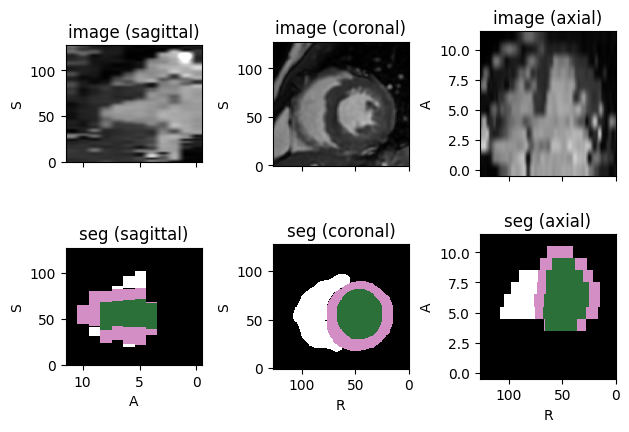

In [52]:
# Visualize one subject
one_subject = testing_dataset[80]
one_subject.plot(channel=1)

# Comparing memory usage

In [28]:
def humanbytes(B):
    """Return the given bytes as a human friendly KB, MB, GB, or TB string."""
    B = float(B)
    KB = float(1024)
    MB = float(KB ** 2) # 1,048,576
    GB = float(KB ** 3) # 1,073,741,824
    TB = float(KB ** 4) # 1,099,511,627,776

    if B < KB:
        return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
    elif KB <= B < MB:
        return '{0:.2f} KB'.format(B / KB)
    elif MB <= B < GB:
        return '{0:.2f} MB'.format(B / MB)
    elif GB <= B < TB:
        return '{0:.2f} GB'.format(B / GB)
    elif TB <= B:
        return '{0:.2f} TB'.format(B / TB)

In [31]:
image_types = ["image", "seg"]
memory_usage = [sum([subject[image].memory for image in image_types]) for subject in train_dataset.dry_iter()]
for i, B in enumerate(memory_usage):
  print(f"Memory used for subject {i}: {humanbytes(B)}")
print("Total memory: ", humanbytes(sum(memory_usage)))

Memory used for subject 0: 3.00 MB
Memory used for subject 1: 2.75 MB
Memory used for subject 2: 2.50 MB
Memory used for subject 3: 3.00 MB
Memory used for subject 4: 3.00 MB
Memory used for subject 5: 2.75 MB
Memory used for subject 6: 3.50 MB
Memory used for subject 7: 2.25 MB
Memory used for subject 8: 3.00 MB
Memory used for subject 9: 3.00 MB
Memory used for subject 10: 2.75 MB
Memory used for subject 11: 2.50 MB
Memory used for subject 12: 2.50 MB
Memory used for subject 13: 2.50 MB
Memory used for subject 14: 2.75 MB
Memory used for subject 15: 2.50 MB
Memory used for subject 16: 3.00 MB
Memory used for subject 17: 2.75 MB
Memory used for subject 18: 1.25 MB
Memory used for subject 19: 1.50 MB
Memory used for subject 20: 3.00 MB
Memory used for subject 21: 2.75 MB
Memory used for subject 22: 3.00 MB
Memory used for subject 23: 2.75 MB
Memory used for subject 24: 3.00 MB
Memory used for subject 25: 3.00 MB
Memory used for subject 26: 2.50 MB
Memory used for subject 27: 2.50 MB
Me